<a href="https://colab.research.google.com/github/ArthurMro/Prediction_marketing/blob/master/Prophet_GA_cs_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forecasting your Google Analytcis traffic with Prophet.

*The explanation about the code can be found on arthurmoreau.com/forecasting-web-traffic*

Based on:
- GA extraction: https://www.youtube.com/watch?v=Xpx--7g6FKk
- Prophet: https://www.youtube.com/watch?v=95-HMzxsghY

In [53]:
from fbprophet import Prophet
import pandas as pd
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
from fbprophet.plot import add_changepoints_to_plot

In [54]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = 'ga-test-api-281612-230ee9ff6b34.json'
VIEW_ID = '193585107' #view cs.info

In [55]:
#Initializing report
def initialize_analyticsreporting():
  credentials = ServiceAccountCredentials.from_json_keyfile_name(
      KEY_FILE_LOCATION, SCOPES)
  analytics = build('analyticsreporting', 'v4', credentials=credentials)
  return analytics

In [56]:
#Get one report page
def get_report(analytics, pageTokenVar):
  return analytics.reports().batchGet(
      body={
        'reportRequests': [
        {
          'viewId': VIEW_ID,
          'dateRanges': [{'startDate': '600daysAgo', 'endDate': 'yesterday'}],
          'metrics': [{'expression': 'ga:sessions'}, {'expression': 'ga:Pageviews'}], #, {'expression': 'ga:Goal completions'} didn't work.
          'dimensions': [{'name': 'ga:Date'}],
          'pageSize': 10000,
          'pageToken': pageTokenVar,
          'samplingLevel': 'LARGE'
        }]
      }
  ).execute()

In [57]:
def handle_report(analytics,pagetoken,rows):  
    response = get_report(analytics, pagetoken)

    #Header, Dimensions Headers, Metric Headers 
    columnHeader = response.get("reports")[0].get('columnHeader', {})
    dimensionHeaders = columnHeader.get('dimensions', [])
    metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])

    #Pagination
    pagetoken = response.get("reports")[0].get('nextPageToken', None)
    
    #Rows
    rowsNew = response.get("reports")[0].get('data', {}).get('rows', [])
    rows = rows + rowsNew
    print("len(rows): " + str(len(rows)))

    #Recursivly query next page
    if pagetoken != None:
        return handle_report(analytics,pagetoken,rows)
    else:
        #nicer results
        nicerows=[]
        for row in rows:
            dic={}
            dimensions = row.get('dimensions', [])
            dateRangeValues = row.get('metrics', [])

            for header, dimension in zip(dimensionHeaders, dimensions):
                dic[header] = dimension

            for i, values in enumerate(dateRangeValues):
                for metric, value in zip(metricHeaders, values.get('values')):
                    if ',' in value or ',' in value:
                        dic[metric.get('name')] = float(value)
                    else:
                        dic[metric.get('name')] = int(value)
            nicerows.append(dic)
        return nicerows

In [58]:
#Start
def main():    
    analytics = initialize_analyticsreporting()
    
    global dfanalytics
    dfanalytics = []

    rows = []
    rows = handle_report(analytics,'0',rows)

    dfanalytics = pd.DataFrame(list(rows))


main()

print(dfanalytics)

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

len(rows): 516
      ga:Date  ga:sessions  ga:Pageviews
0    20190416            5             6
1    20190417            6            19
2    20190418            1             1
3    20190419           11            11
4    20190420            5             6
..        ...          ...           ...
511  20201013           37            74
512  20201014           41            63
513  20201015           23            49
514  20201016           28            53
515  20201017           21            40

[516 rows x 3 columns]


# 2. Prophet

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


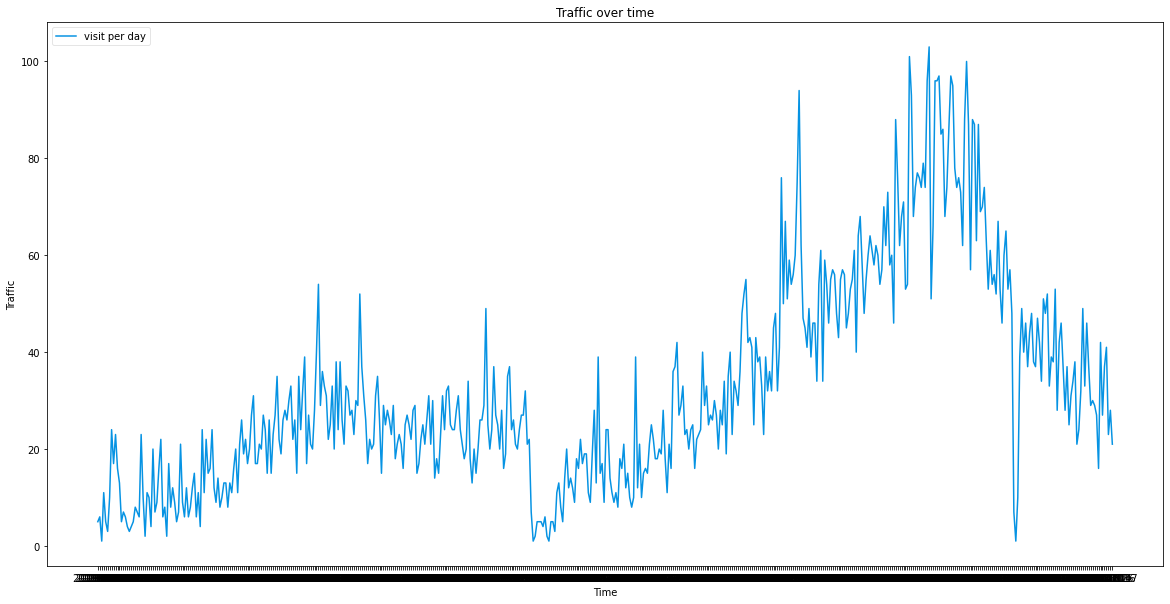

In [64]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set(title='Traffic over time',xlabel= "Time", ylabel='Traffic')
ax1.plot(dfanalytics['ga:Date'], dfanalytics['ga:sessions'], label='visit per day', color='#0693e3')
ax1.legend(loc='upper left', frameon=True, framealpha = 0.5 )


## 2.1. Trial one: 300 days

The model seems to have not enough data to perform well when I take only 300 days. This part of the analysis was let out and we focused on using 600 days of data.

## 2.2. Trial two: 600 days

###2.2.1 Train

#### 2.2.1.1 Creating dataset

In [65]:
df = dfanalytics

In [66]:
df['ds'] = pd.to_datetime(df['ga:Date'])
df.rename(columns={'ga:sessions': 'y'}, inplace= True)
df.drop(['ga:Date', 'ga:Pageviews'], axis=1, inplace=True)

print(df.head())

    y         ds
0   5 2019-04-16
1   6 2019-04-17
2   1 2019-04-18
3  11 2019-04-19
4   5 2019-04-20


#### 2.2.1.2 Removing outliers

From the 27th to the 30th of August included, the data was skewed by a website crash. We will thus replace these values by value in the range of the values around: between 54 and 40, gradually decreasing.

In [69]:
df.loc[df.ds == '2020-08-27 00:00:00', 'y'] = 43
df.loc[df.ds == '2020-08-28 00:00:00', 'y'] = 40
df.loc[df.ds == '2020-08-29 00:00:00', 'y'] = 44
df.loc[df.ds == '2020-08-30 00:00:00', 'y'] = 44

In [70]:
df.tail(30)

,y,ds
486,53,2020-09-18
487,28,2020-09-19
488,42,2020-09-20
489,46,2020-09-21
490,37,2020-09-22
491,28,2020-09-23
492,37,2020-09-24
493,25,2020-09-25
494,31,2020-09-26
495,34,2020-09-27


In this second part, I need to cope with the crash that I got between the 23rd of November and the 28th of December. For that I'll grab back the trends of the data from the Google Trends, mutiplied it by a base of 10 visitors and add a random factor between -3 and 3.
Note: this factors weakens the prediction, but can still be considered a valid proxy. Indeed Google Trends shows the amount of search for a keyword, and the traffic for the website studied is 100% organic (=non-paid), so it follows the same pattern. 


Here is the results: 
# 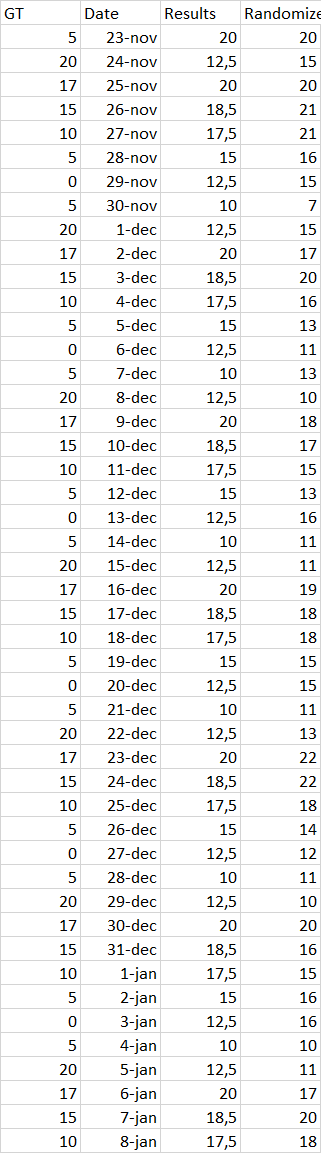


Let's first add the missing dates to the df.

In [71]:
df.ds.head()

0   2019-04-16
1   2019-04-17
2   2019-04-18
3   2019-04-19
4   2019-04-20
Name: ds, dtype: datetime64[ns]

In [72]:
missing_dates = pd.date_range(start = '2019-04-16', end = '2019-12-29' ).difference(df['ds'])
print(missing_dates)

DatetimeIndex(['2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-30', '2019-12-01',
               '2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05',
               '2019-12-06', '2019-12-07', '2019-12-08', '2019-12-09',
               '2019-12-10', '2019-12-11', '2019-12-12', '2019-12-13',
               '2019-12-14', '2019-12-15', '2019-12-16', '2019-12-17',
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-21',
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27'],
              dtype='datetime64[ns]', freq=None)


In [73]:
df_missing_dates = pd.DataFrame(missing_dates)
df_missing_dates.columns = ['ds']
list_replace_values = [20, 15, 20, 21, 21, 16, 7, 15, 17, 20, 16, 13, 11, 13, 10, 18, 17, 15, 13, 16, 11, 11, 19, 18, 18, 15, 15, 22, 21, 11, 13, 9, 7, 4]
df_missing_dates['y'] = list_replace_values

Now I will have to concat and then sort to have a nice df.

In [74]:
df = pd.concat([df, df_missing_dates])
df['cap'] = 120
df['floor'] = 0

In [75]:
df.sort_values('ds', inplace=True)

Now let's implement this change. Edit: doing it 'by hand' doesn't work. I remove a whole section where I was adding line by line the values on the missing dates.

Second try: didn't work. Seems that we have a problem of data types. I was flipping the table multiple time, but finally found a way around and delete the trial part of the code.

In [76]:
df.reset_index(inplace=True)

In [77]:
df[200:240]

,index,y,ds,cap,floor
200,200,24,2019-11-02,120,0
201,201,37,2019-11-03,120,0
202,202,27,2019-11-04,120,0
203,203,25,2019-11-05,120,0
204,204,20,2019-11-06,120,0
205,205,28,2019-11-07,120,0
206,206,16,2019-11-08,120,0
207,207,19,2019-11-09,120,0
208,208,35,2019-11-10,120,0
209,209,37,2019-11-11,120,0


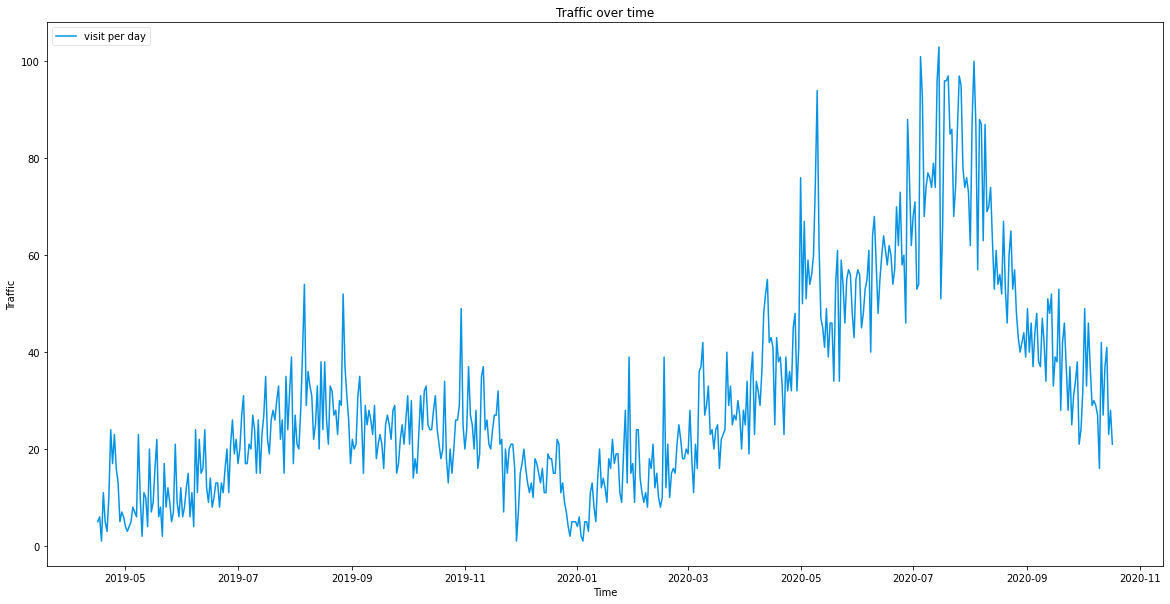

In [80]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set(title='Traffic over time',xlabel= "Time", ylabel='Traffic')
ax1.plot(df['ds'], df['y'], label='visit per day', color='#0693e3')
ax1.legend(loc='upper left', frameon=True, framealpha = 0.5 )

####2.2.1.3 Tweaking the model

Now while creating the model, we'll tweak some default paramters. Indeed the previous model was clearly underfitting.


*   We'll add seasonality_mode='multiplicative' as parameters, because the seasonality grows in influence
*   changepoint_prior_scale=0.5 to cope with the underfitting. Increasing makes the trends more flexible (so visually broadening the end funnel)
*   A cap of 50k and a floor of 0 in the dataset (just above)
*   yearly.seasonality = 20. It was 10 but I want more





In [81]:
model = Prophet(changepoint_prior_scale=0.5, changepoint_range=0.9, seasonality_mode='multiplicative', yearly_seasonality = 10)
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [82]:
#Forecasting
future = model.make_future_dataframe(periods= 60)
future['cap'] = 120
future['floor'] = 0
print(future.tail())

            ds  cap  floor
605 2020-12-12  120      0
606 2020-12-13  120      0
607 2020-12-14  120      0
608 2020-12-15  120      0
609 2020-12-16  120      0


In [83]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
605,2020-12-12,27.901232,120,1.833397,21.168937,26.640185,29.104127,-0.578903,-0.578903,-0.578903,-0.069608,-0.069608,-0.069608,-0.509295,-0.509295,-0.509295,0.0,0.0,0.0,11.749133
606,2020-12-13,27.811544,120,6.681659,25.889846,26.514951,29.063448,-0.402369,-0.402369,-0.402369,0.112206,0.112206,0.112206,-0.514576,-0.514576,-0.514576,0.0,0.0,0.0,16.621027
607,2020-12-14,27.721855,120,6.032595,25.574712,26.391768,29.014386,-0.433382,-0.433382,-0.433382,0.088605,0.088605,0.088605,-0.521986,-0.521986,-0.521986,0.0,0.0,0.0,15.707713
608,2020-12-15,27.632166,120,3.831993,23.528617,26.277995,28.964652,-0.502417,-0.502417,-0.502417,0.029194,0.029194,0.029194,-0.531611,-0.531611,-0.531611,0.0,0.0,0.0,13.749290
609,2020-12-16,27.542478,120,1.871646,22.575267,26.153996,28.909480,-0.552038,-0.552038,-0.552038,-0.008571,-0.008571,-0.008571,-0.543467,-0.543467,-0.543467,0.0,0.0,0.0,12.337973


In [84]:
forecast.columns

Index(['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'yhat'],
      dtype='object')

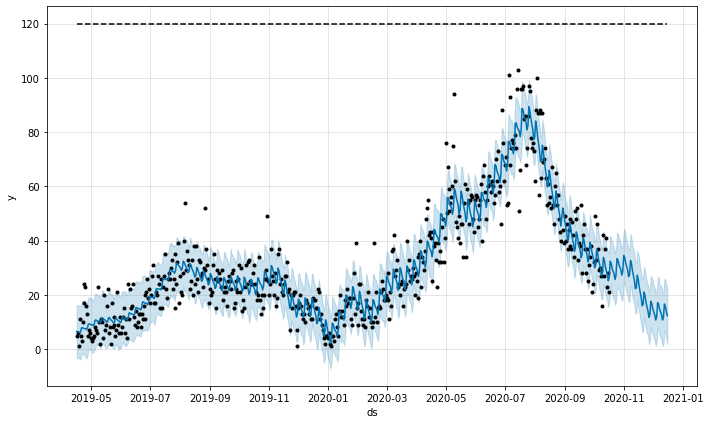

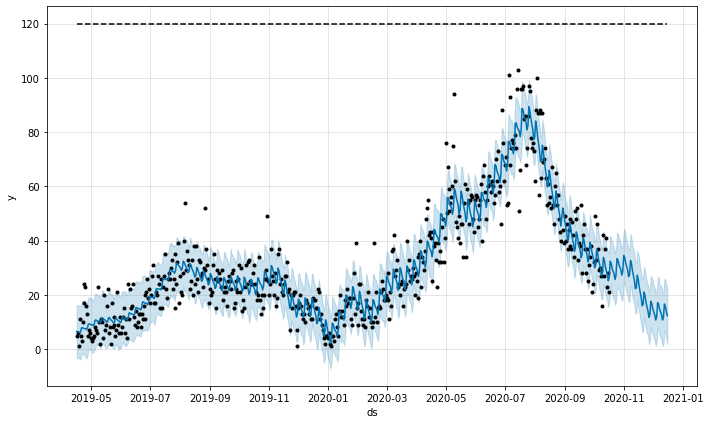

In [85]:
model.plot(forecast)

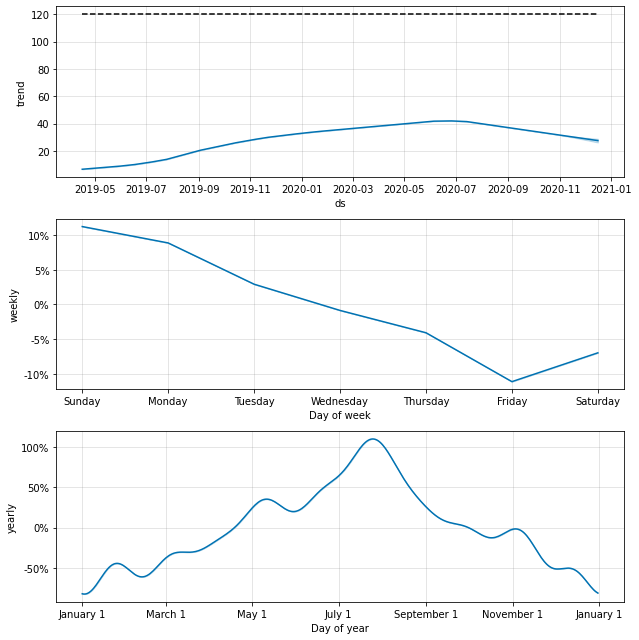

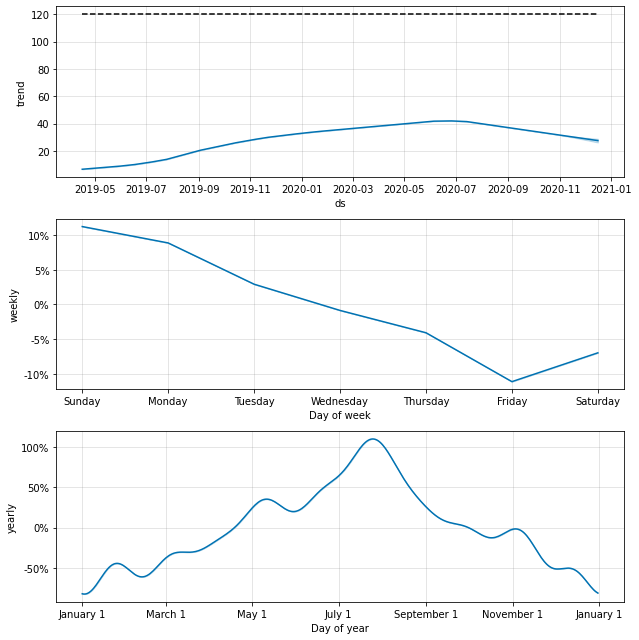

In [86]:
model.plot_components(forecast)

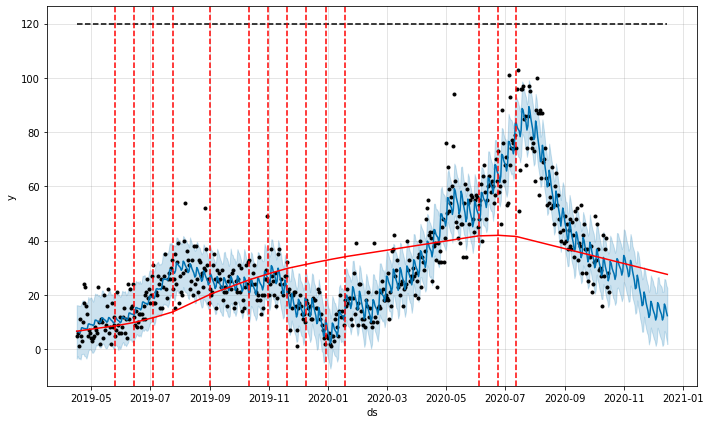

In [87]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

### 2.2.2 Test

In [89]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '30 days', parallel="processes")
df_cv.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2020-04-20 00:00:00 and 2020-09-17 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7febd8468eb8>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-04-21,43.656911,35.763827,51.309165,33,2020-04-20
1,2020-04-22,40.172376,32.784616,47.298430,23,2020-04-20
2,2020-04-23,39.619786,31.205245,47.559484,39,2020-04-20
3,2020-04-24,34.311108,27.117740,41.792433,32,2020-04-20
4,2020-04-25,37.004775,29.073030,44.891977,36,2020-04-20


In [30]:
# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(20)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,124.697970,11.166825,8.360601,0.158313,0.085421,0.698864
1,4 days,115.168802,10.731673,8.164205,0.158529,0.083599,0.667614
2,5 days,105.934131,10.292431,7.666193,0.128085,0.082615,0.661932
3,6 days,105.457772,10.269263,7.990307,0.142527,0.107853,0.639205
4,7 days,115.677899,10.755366,7.714422,0.139755,0.099899,0.667614
5,8 days,149.839612,12.240899,9.294102,0.189186,0.132196,0.571023
6,9 days,195.514302,13.982643,11.157277,0.223712,0.194044,0.480114
7,10 days,204.351743,14.295165,12.462643,0.246753,0.200235,0.394886
8,11 days,303.209529,17.412913,14.814693,0.272110,0.200235,0.343750
9,12 days,362.513938,19.039799,16.546801,0.317745,0.273756,0.250000


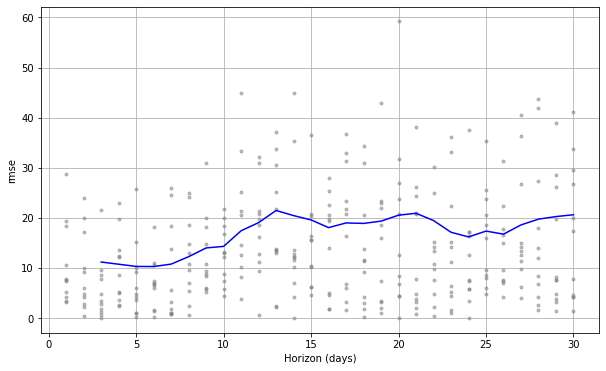

In [31]:
# Visualizing the performance metrics
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

Final step: savign the forecast as txt. That's for the sake of the visualization.

In [32]:
forecast[['ds', 'yhat']].to_csv('forecast.txt',index=False, header=False)

#3. Animation

It's time to make a funny graphical animation of the plot.
I followed the tutorial here: https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c
https://www.youtube.com/watch?v=ZmYPzESC5YY
https://medium.com/datadriveninvestor/time-series-animation-in-matplotlib-de023655a197

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib import style
from datetime import datetime
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib inline

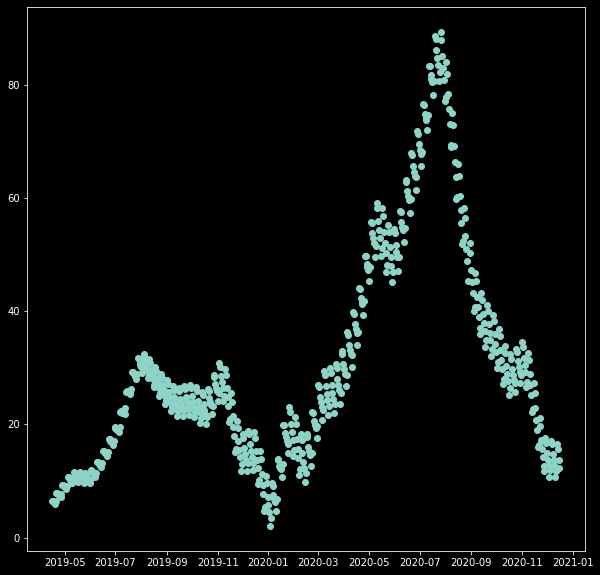

In [34]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(10,10))
    plt.subplot(1,1,1)
    plt.plot(forecast['ds'], forecast['yhat'], linewidth=0,marker="o")

In [35]:
forecast.head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-04-16,6.601357,120,-2.938669,15.834493,6.601357,6.601357,-0.014502,-0.014502,-0.014502,0.029194,0.029194,0.029194,-0.043696,-0.043696,-0.043696,0.0,0.0,0.0,6.505628
1,2019-04-17,6.650827,120,-3.258457,16.148742,6.650827,6.650827,-0.038098,-0.038098,-0.038098,-0.008571,-0.008571,-0.008571,-0.029527,-0.029527,-0.029527,0.0,0.0,0.0,6.397444
2,2019-04-18,6.700297,120,-3.861471,15.210007,6.700297,6.700297,-0.055359,-0.055359,-0.055359,-0.040710,-0.040710,-0.040710,-0.014649,-0.014649,-0.014649,0.0,0.0,0.0,6.329374
3,2019-04-19,6.749767,120,-4.241328,15.917862,6.749767,6.749767,-0.110120,-0.110120,-0.110120,-0.111116,-0.111116,-0.111116,0.000996,0.000996,0.000996,0.0,0.0,0.0,6.006481
4,2019-04-20,6.799236,120,-3.332167,16.842104,6.799236,6.799236,-0.052160,-0.052160,-0.052160,-0.069608,-0.069608,-0.069608,0.017448,0.017448,0.017448,0.0,0.0,0.0,6.444590


##3.1 Creating the frame

In [36]:
df_merge = forecast.merge(df, on='ds', how = 'left')

In [37]:
df_merge.tail()

,ds,trend,cap_x,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,index,y,cap_y,floor
605,2020-12-12,27.901232,120,1.407252,21.950077,26.610378,29.237766,-0.578903,-0.578903,-0.578903,-0.069608,-0.069608,-0.069608,-0.509295,-0.509295,-0.509295,0.0,0.0,0.0,11.749133,NaN,NaN,NaN,NaN
606,2020-12-13,27.811544,120,7.437673,26.281989,26.482547,29.174657,-0.402369,-0.402369,-0.402369,0.112206,0.112206,0.112206,-0.514576,-0.514576,-0.514576,0.0,0.0,0.0,16.621027,NaN,NaN,NaN,NaN
607,2020-12-14,27.721855,120,6.776484,25.099105,26.340663,29.124772,-0.433382,-0.433382,-0.433382,0.088605,0.088605,0.088605,-0.521986,-0.521986,-0.521986,0.0,0.0,0.0,15.707713,NaN,NaN,NaN,NaN
608,2020-12-15,27.632166,120,4.323583,22.940600,26.207355,29.067656,-0.502417,-0.502417,-0.502417,0.029194,0.029194,0.029194,-0.531611,-0.531611,-0.531611,0.0,0.0,0.0,13.749290,NaN,NaN,NaN,NaN
609,2020-12-16,27.542478,120,2.735499,21.776636,26.064392,29.008417,-0.552038,-0.552038,-0.552038,-0.008571,-0.008571,-0.008571,-0.543467,-0.543467,-0.543467,0.0,0.0,0.0,12.337973,NaN,NaN,NaN,NaN


This next paragraph was a pain. I had to download the video each time I wanted feedback.
For GIF everyone suggest Imagemagick with I can't install. So I try now with Pillowriter. FFmepg was only giving me mp4.

Now, that I could get the GIF, I need to only animate a part of my graph: the prediction.

I forgot to add the labels and titles and it's quite a pain, they never appears and I don't where to place the lines of code.
Now I understood that what I put at the beginning, in the "with" appears in my jupiter and what in put in the "def animate" appears in the gif. But one info doesn't ever appears on both.

Ok finally I got it. It was quite nerve-wrecking, I never flipped so many tables. The code was cleaned of all swear words and unecessary elements.

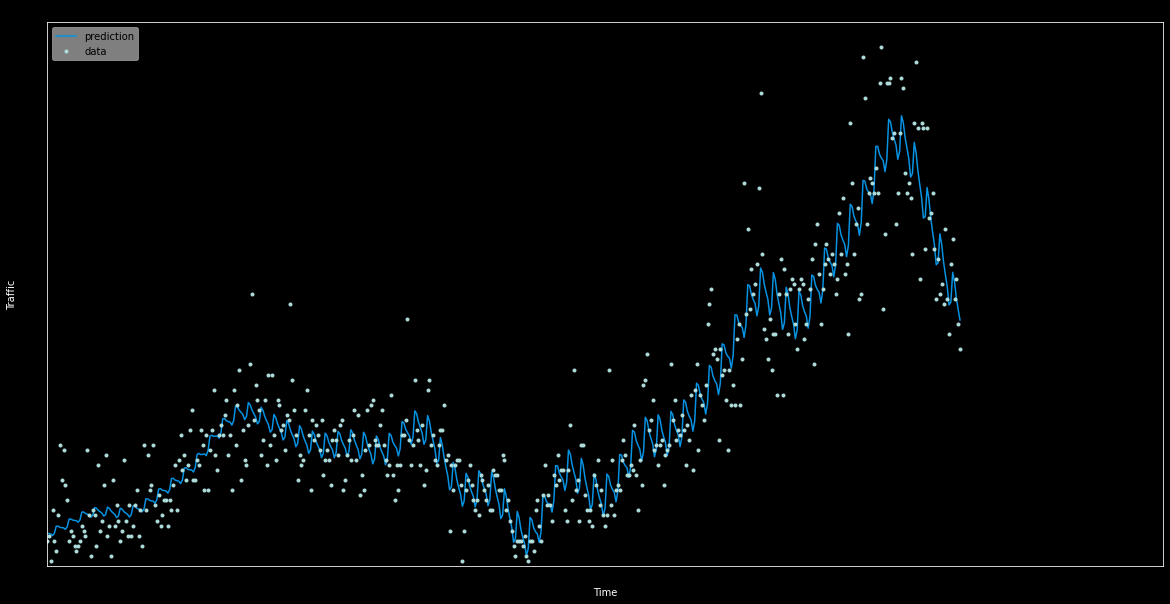

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [38]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(20,10))
    #creating a subplot 
    ax1 = fig.add_subplot(1,1,1)




    def animate(i):

        lines =  df_merge.iloc[0:int(i+500)] #   set the variable data to contain 0 to the (i+1)th row. I wanted only the prediction, so put 535.
        xs = []                         # I put  df_merge.iloc[0:int(i+535)] with a zero starting point, it understands EXACTLY what I want!
        ys = []
        zs = []
        for line in lines:
            if len(line)>1:
                xs = lines['ds']
                ys = lines['yhat']
                zs = lines['y']

        ax1.clear()
        
        ax1.set(title='Predicting the future traffic of my website',xlabel= "Time", ylabel='Traffic')
        ax1.axis(xmin= (df_merge['ds'].min()), xmax=(df_merge['ds'].max())) #XX I should add margin here too.
        ax1.axis(ymin= (df_merge['y'].min()-1), ymax=(df_merge['y'].max()+5)) #adding a bit of margin with -1 and +5

        ax1.plot(xs, ys, label='prediction', color='#0693e3')
        ax1.plot(xs, zs, marker = '.' ,linewidth = 0.0, label='data', color='#afdedc') #linewidth is not visible at 0.1, I change to 0.3
        ax1.legend(loc='upper left', frameon=True, framealpha = 0.5 )
        



writergif = animation.PillowWriter(fps=30) 

ani = animation.FuncAnimation(fig, animate, frames = (len(forecast)-len(df)+30), interval=10) #the amount of frames had to be changed quite a lot to make a stop at the end.

plt.show()

writergif = animation.PillowWriter(fps=30, metadata=dict(artist='Arthur_Moreau')) 
ani.save('animation_video.gif', writer=writergif)